# Online to Offline: where is the best place to settle?

## Intro

This project aims to assist online businesses to go offline by helping them choosing the best place to open their physical location close to their customers.

### How does the model work?

1. Gather the geographical information of users (coordinates/addresses)
2. Define a unique location for each user (mean)
3. Build clusters to regroup users
4. Analyze the clusters’ regions
5. Find the best spot to rent / buy a place (via Zap Imóveis)

### For whom it can be useful?


Any business that has its customer locations, such as:

1. Restaurants with Delivery Customer data
2. Companies that want to move their office
3. E-commerce shops that wish to implement storage closer to their clients

## 1. Data: importing and cleaning

As an exemple, we worked with coordinates data from an app. They wanted to find the best spot to build a physical location, based on their clients' locations and some other info. We used their data to understand their clients' and places' coordinates and to group them geographically:

In [1]:
# Import the libraries:

import pandas as pd
import numpy as np
from datetime import datetime
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
from haversine import haversine
import zapimoveis_scraper as zap

###  1.1: clients' data

Content: all clients registered in the app and their cellphones' coordinates from when they logged in the app.

In [2]:
# Read in the data
clients = pd.read_csv('clients.csv')
clients

,ClientID,Latitude,Longitude
0,0CKK929069SJS62S6496J49S4KJ06006,"-23,538102261400002","-46,6594936878"
1,8KE6K416ESEJEC1K0KDK464EDDS4SJJK,"-3,8562209250000006","-38,50561068375"
2,42J6J2K0D499JCCE4CSEK6S8E6E4D104,"-7,24871575837592","-35,90138356663675"
3,44006C060SC0486401DJ084DJ6S00691,"-23,538102261400002","-46,6594936878"
4,8C6EDK421J04SJ4SJ4D6894J0K146K11,"-15,833858484894211","-48,044801756030175"
...,...,...,...
840917,6S9D9DJ012028246489266S42CEC8640,"-23,538102261400002","-46,6594936878"
840918,9J066EESE064D8J810SK6D6S6000DDS9,NaN,NaN
840919,2K26S92D484DE22892400J06KE0E40J2,"-23,574772627045004","-23,598359192954998"
840920,88CCC10KE0489D26K90KKJ06964CJ820,"-22,287723563500002","-53,28489663375"


The clients' table has more than 840k rows (one for each client) and 3 columns. There are some clients with 'NaN' values at 
'Latitude' and 'Longitude' so we'll have to drop them.

In [3]:
# Drop clients with 'NaN' values
clients_clean = clients.copy()
clients_clean.dropna(axis=0, how='any', inplace=True)

# Edit names to snake_case convention
clients_clean.rename(columns={'ClientID' : 'client_id', 'Latitude' : 'latitude', 'Longitude' : 'longitude'}, inplace=True)

# Create new column to keep track of the origin
clients_clean['origin'] = 'C'

# Create 'coordinates' column (latitude||longitude) and round to 6 decimals
clients_clean['latitude'] = clients_clean['latitude'].str.replace(',', '.').astype(float)
clients_clean['longitude'] = clients_clean['longitude'].str.replace(',', '.').astype(float)
clients_clean['coordinates'] = round(clients_clean['latitude'], 6).astype(str) + ',' +\
                               round(clients_clean['longitude'], 6).astype(str)
clients_clean.reset_index(drop=True, inplace=True)
clients_clean

,client_id,latitude,longitude,origin,coordinates
0,0CKK929069SJS62S6496J49S4KJ06006,-23.538102,-46.659494,C,"-23.538102,-46.659494"
1,8KE6K416ESEJEC1K0KDK464EDDS4SJJK,-3.856221,-38.505611,C,"-3.856221,-38.505611"
2,42J6J2K0D499JCCE4CSEK6S8E6E4D104,-7.248716,-35.901384,C,"-7.248716,-35.901384"
3,44006C060SC0486401DJ084DJ6S00691,-23.538102,-46.659494,C,"-23.538102,-46.659494"
4,8C6EDK421J04SJ4SJ4D6894J0K146K11,-15.833858,-48.044802,C,"-15.833858,-48.044802"
...,...,...,...,...,...
582060,J160CE6J0KJSESC12E04J69DCE060406,-26.914254,-49.147339,C,"-26.914254,-49.147339"
582061,6408K86080440S6KCKES6DSC44K6C88S,-23.538102,-46.659494,C,"-23.538102,-46.659494"
582062,6S9D9DJ012028246489266S42CEC8640,-23.538102,-46.659494,C,"-23.538102,-46.659494"
582063,2K26S92D484DE22892400J06KE0E40J2,-23.574773,-23.598359,C,"-23.574773,-23.598359"


With this first step of cleaning, we dropped more than 200k clients from the original table.


Before moving on to the next tables, we have to check the coordinates' frequency.

In [4]:
# Frequency table for 'coordinates' column
clients_clean['coordinates'].value_counts().head(30)

-23.538102,-46.659494    232968
-23.538102,-46.659495      1758
0.0,0.0                     117
-23.538093,-46.659495        34
37.615175,-122.495024        24
-23.558569,-46.684566         9
-10.935949,-51.777206         9
-12.637084,-54.413534         7
-23.534345,-46.67354          6
-14.25391,-41.602045          6
-23.550174,-46.651957         6
31.233535,121.548642          5
-9.152854,38.780086           5
-23.538745,-46.656625         5
-23.538091,-46.659495         5
-23.57415,-46.754261          4
-3.730852,-38.54626           4
-23.527251,-46.66501          4
-23.582674,-46.714771         4
-15.77211,-47.953965          4
-12.9935,-54.027              4
-22.942223,-47.085938         3
-23.163101,-50.66311          3
-6.848247,-39.552835          3
-23.517992,-46.760196         3
-23.619786,-46.616097         3
-23.553783,-46.357179         3
-25.387755,-49.271518         3
-22.547371,-44.172038         2
-16.377882,-39.601849         2
Name: coordinates, dtype: int64

There are 232,968 rows with the same coordinate and also several others repeated values. We checked on Google Maps and concluded that they're default coordinate's values for clients without location data, so we'll drop the rows with the top 27 coordinates (3 or more repetitions).

In [5]:
# Extract and apply this coordinates to a variable
bad_coordinates_C = clients_clean['coordinates'].value_counts().index[:27]
bad_coordinates_C

Index(['-23.538102,-46.659494', '-23.538102,-46.659495', '0.0,0.0',
       '-23.538093,-46.659495', '37.615175,-122.495024',
       '-23.558569,-46.684566', '-10.935949,-51.777206',
       '-12.637084,-54.413534', '-23.534345,-46.67354', '-14.25391,-41.602045',
       '-23.550174,-46.651957', '31.233535,121.548642', '-9.152854,38.780086',
       '-23.538745,-46.656625', '-23.538091,-46.659495',
       '-23.57415,-46.754261', '-3.730852,-38.54626', '-23.527251,-46.66501',
       '-23.582674,-46.714771', '-15.77211,-47.953965', '-12.9935,-54.027',
       '-22.942223,-47.085938', '-23.163101,-50.66311', '-6.848247,-39.552835',
       '-23.517992,-46.760196', '-23.619786,-46.616097',
       '-23.553783,-46.357179'],
      dtype='object')

In [6]:
# Remove rows from clients_clean with the 'bad' coordinates
for coords in bad_coordinates_C:
    clients_clean = clients_clean[clients_clean['coordinates'] != coords]
clients_clean.reset_index(drop=True, inplace=True)
clients_clean

,client_id,latitude,longitude,origin,coordinates
0,8KE6K416ESEJEC1K0KDK464EDDS4SJJK,-3.856221,-38.505611,C,"-3.856221,-38.505611"
1,42J6J2K0D499JCCE4CSEK6S8E6E4D104,-7.248716,-35.901384,C,"-7.248716,-35.901384"
2,8C6EDK421J04SJ4SJ4D6894J0K146K11,-15.833858,-48.044802,C,"-15.833858,-48.044802"
3,69226KJ46602J9K86E44JD6JKSD94460,-26.445487,-53.533683,C,"-26.445487,-53.533683"
4,CS4CJ99K1E4864E8K0K606E4S8J04D81,-28.807383,-52.512776,C,"-28.807383,-52.512776"
...,...,...,...,...,...
347054,S040D2S801CSSJ00E4J94EDECJ86DS4C,-12.935948,-38.503382,C,"-12.935948,-38.503382"
347055,18004660J8K610J06K4660J9006J9CD1,-23.661293,-46.872821,C,"-23.661293,-46.872821"
347056,J160CE6J0KJSESC12E04J69DCE060406,-26.914254,-49.147339,C,"-26.914254,-49.147339"
347057,2K26S92D484DE22892400J06KE0E40J2,-23.574773,-23.598359,C,"-23.574773,-23.598359"


After this cleaning step we remained with 347,059 real clients with real coordinates.


Now it's time to import and work on the places' table.

###  1.2: places' data

Content: all places registered in the app, where clients gather.

In [7]:
places = pd.read_csv('places.csv')
places

,PlaceID,Latitude,Longitude
0,9JJD0E8J8C18K480EK48690C4C148J40,"-20,33092033000468","-40,30397698859132"
1,D8J24D4C094D4D946E626DJJ0C80JD00,"-23,5422679775","-46,6553990415"
2,C06J12266E4E08260D609E44904EE6KJ,"-6,835404388100001","-35,78533942785"
3,E6DDS64JSK2988CE800011EEE16JESES,"-23,612653709411607","-46,718511308669996"
4,SJ146J969CE4J449J962E0DC4J0444S0,"-23,6720854363","-46,56584378625"
...,...,...,...
1358675,6JK1S96J962246EJ666ESDJ90E466022,"-19,510573833","-41,03253751574999"
1358676,9KSK26S0D191KKKKE409840JDDJC62S4,"-22,86750582735","-43,42760645175"
1358677,S9K1J0E60K4E64244CD6D4601DSCE20C,"-23,562574620246927","-46,55467210578919"
1358678,01K48CJ21164DCSD0C06116400E6C280,"-27,41436732234379","-48,446238653864725"


In [8]:
# Work on a copy of places
places_clean = places.copy()

# Same steps we did on clients' table
places_clean = places_clean.rename(columns={'PlaceID': 'place_id', 'Latitude' : 'latitude' , 'Longitude' : 'longitude'})
places_clean['latitude'] = places_clean['latitude'].str.replace(',', '.').astype(float)
places_clean['longitude'] = places_clean['longitude'].str.replace(',', '.').astype(float)
places_clean['coordinates'] = round(places_clean['latitude'], 6).astype(str) + ',' +\
                              round(places_clean['longitude'], 6).astype(str)
places_clean['origin'] = 'M'
places_clean.reset_index(inplace=True, drop=True)
places_clean

,place_id,latitude,longitude,coordinates,origin
0,9JJD0E8J8C18K480EK48690C4C148J40,-20.330920,-40.303977,"-20.33092,-40.303977",M
1,D8J24D4C094D4D946E626DJJ0C80JD00,-23.542268,-46.655399,"-23.542268,-46.655399",M
2,C06J12266E4E08260D609E44904EE6KJ,-6.835404,-35.785339,"-6.835404,-35.785339",M
3,E6DDS64JSK2988CE800011EEE16JESES,-23.612654,-46.718511,"-23.612654,-46.718511",M
4,SJ146J969CE4J449J962E0DC4J0444S0,-23.672085,-46.565844,"-23.672085,-46.565844",M
...,...,...,...,...,...
1358675,6JK1S96J962246EJ666ESDJ90E466022,-19.510574,-41.032538,"-19.510574,-41.032538",M
1358676,9KSK26S0D191KKKKE409840JDDJC62S4,-22.867506,-43.427606,"-22.867506,-43.427606",M
1358677,S9K1J0E60K4E64244CD6D4601DSCE20C,-23.562575,-46.554672,"-23.562575,-46.554672",M
1358678,01K48CJ21164DCSD0C06116400E6C280,-27.414367,-48.446239,"-27.414367,-48.446239",M


In [9]:
# Frequency table for 'coordinates' column
places_clean['coordinates'].value_counts().head(10)

-28.724317,-49.500521    22205
-23.542268,-46.655399    13664
-23.707761,-45.481201    11016
-23.538078,-46.659498     8663
-23.538102,-46.659494     6801
-23.527251,-46.665009     4134
-23.543462,-46.665481     3614
-23.511759,-46.766785     3108
-23.558569,-46.684566     2486
-23.525007,-46.661266     2081
Name: coordinates, dtype: int64

Checking the coordinates on Google Maps, we can conclude that:

- The 4th and 5th are the same default coordinates from clients, so we'll drop them;
- There are some places in this list that seems a bit odd (specially the 1st one), but we can't discard them for now;

In [10]:
# Extract and apply this coordinates to a variable
bad_coordinates_M = [places_clean['coordinates'].value_counts().index[3],
                     places_clean['coordinates'].value_counts().index[4]]

# Remove rows from places_clean with the 'bad' coordinates
for coords in bad_coordinates_M:
    places_clean = places_clean[places_clean['coordinates'] != coords]
places_clean.reset_index(drop=True, inplace=True)
places_clean

,place_id,latitude,longitude,coordinates,origin
0,9JJD0E8J8C18K480EK48690C4C148J40,-20.330920,-40.303977,"-20.33092,-40.303977",M
1,D8J24D4C094D4D946E626DJJ0C80JD00,-23.542268,-46.655399,"-23.542268,-46.655399",M
2,C06J12266E4E08260D609E44904EE6KJ,-6.835404,-35.785339,"-6.835404,-35.785339",M
3,E6DDS64JSK2988CE800011EEE16JESES,-23.612654,-46.718511,"-23.612654,-46.718511",M
4,SJ146J969CE4J449J962E0DC4J0444S0,-23.672085,-46.565844,"-23.672085,-46.565844",M
...,...,...,...,...,...
1343211,6JK1S96J962246EJ666ESDJ90E466022,-19.510574,-41.032538,"-19.510574,-41.032538",M
1343212,9KSK26S0D191KKKKE409840JDDJC62S4,-22.867506,-43.427606,"-22.867506,-43.427606",M
1343213,S9K1J0E60K4E64244CD6D4601DSCE20C,-23.562575,-46.554672,"-23.562575,-46.554672",M
1343214,01K48CJ21164DCSD0C06116400E6C280,-27.414367,-48.446239,"-27.414367,-48.446239",M


After this step, we remain with 1,343,216 places with clean and plausible coordinates.

### 1.3: relational table between clients and places

Content: all clients registered at every place

In [11]:
clientsplaces = pd.read_csv('clients&places.csv')
clientsplaces

,ClientID,PlaceID
0,6S04S46KS49600K1284C4044J626SED2,12DCJ006JE02E60J6C061D1K646604E9
1,E42248CE8C0E926DK0D0E16S6E4D6D46,K98J20SC66D94400E400JS4E1KK1S10J
2,8824648E04E604J0S44KS44E1SDS12S0,CS1J06CDC10J6K01KD61J2DEJ20K941D
3,4146C8S8684EJJ0JJ1111411J66JK19S,D1EK8KCE4D81K124D44K6S64C0K0E606
4,K22096968904604046D1K16648CCC0ES,DE4SD66802E06K04048482S06D040C4K
...,...,...
2860588,J602ES6J02K8EE404262D40E6492J80E,0924KJ40D906S4JE6S221414D0J01040
2860589,6CD4J6069C41S8K0644021E690461S89,9066JC120919E4D9401D48DK12CC129J
2860590,19K0D6ES01C09SJEJ0DDEDJ6984E0J60,4694S84DJD6EK00C649446K284D80CDJ
2860591,DD660C1264E6K4D628S4E9DC1440E6E4,K16EJ284S84K91928214K6DDJS262CJ0


In [12]:
# Same steps as before
clientsplaces_clean = clientsplaces.copy()
clientsplaces_clean.columns = ['client_id', 'place_id']
clientsplaces_clean.reset_index(inplace=True, drop=True)
clientsplaces_clean

,client_id,place_id
0,6S04S46KS49600K1284C4044J626SED2,12DCJ006JE02E60J6C061D1K646604E9
1,E42248CE8C0E926DK0D0E16S6E4D6D46,K98J20SC66D94400E400JS4E1KK1S10J
2,8824648E04E604J0S44KS44E1SDS12S0,CS1J06CDC10J6K01KD61J2DEJ20K941D
3,4146C8S8684EJJ0JJ1111411J66JK19S,D1EK8KCE4D81K124D44K6S64C0K0E606
4,K22096968904604046D1K16648CCC0ES,DE4SD66802E06K04048482S06D040C4K
...,...,...
2860588,J602ES6J02K8EE404262D40E6492J80E,0924KJ40D906S4JE6S221414D0J01040
2860589,6CD4J6069C41S8K0644021E690461S89,9066JC120919E4D9401D48DK12CC129J
2860590,19K0D6ES01C09SJEJ0DDEDJ6984E0J60,4694S84DJD6EK00C649446K284D80CDJ
2860591,DD660C1264E6K4D628S4E9DC1440E6E4,K16EJ284S84K91928214K6DDJS262CJ0


This process leaves us with 2,860,593 rows.

## 2. Prepping the model's input

Now that we've imported and cleaned the raw data, we can begin the process of merging. Our goal here is to have a dataframe with all real clients and their cellphones' coordinates (C) along with their places' coordinates (M).

### 2.1: merging


First, we merge the 'clients_clean' with the 'clientsplaces_clean' on 'client_id', and keep only the clients that actually went to some place at least once.

In [13]:
real_clients = clients_clean.merge(clientsplaces_clean, how='inner', on='client_id')
real_clients

,client_id,latitude,longitude,origin,coordinates,place_id
0,8C6EDK421J04SJ4SJ4D6894J0K146K11,-15.833858,-48.044802,C,"-15.833858,-48.044802",94J822JEEKJDSK681E006C4J0CK9KJ1E
1,8C6EDK421J04SJ4SJ4D6894J0K146K11,-15.833858,-48.044802,C,"-15.833858,-48.044802",0EJ846KD0408JJ68E114222S00069JSJ
2,8C6EDK421J04SJ4SJ4D6894J0K146K11,-15.833858,-48.044802,C,"-15.833858,-48.044802",K4214J4JS0J9K8D4600408EKK8840J01
3,8C6EDK421J04SJ4SJ4D6894J0K146K11,-15.833858,-48.044802,C,"-15.833858,-48.044802",0ECSDEJ6EE061402C4446144E992401K
4,8C6EDK421J04SJ4SJ4D6894J0K146K11,-15.833858,-48.044802,C,"-15.833858,-48.044802",1898CK6609SC810JC041K04D42869010
...,...,...,...,...,...,...
1057068,J062J4E84096SS06E1DK606660KJE2DK,-8.133085,-41.156768,C,"-8.133085,-41.156768",D404S0DK442S1602D210C1E44K4D6142
1057069,J062J4E84096SS06E1DK606660KJE2DK,-8.133085,-41.156768,C,"-8.133085,-41.156768",841K024124K969E09JS800S029402ES0
1057070,J062J4E84096SS06E1DK606660KJE2DK,-8.133085,-41.156768,C,"-8.133085,-41.156768",D49E81990KSC84K89900ES4496D60ES8
1057071,J062J4E84096SS06E1DK606660KJE2DK,-8.133085,-41.156768,C,"-8.133085,-41.156768",6ED4CK410010JK044411128DCE1E1604


Now we have a 'real_clients' dataframe, with more than 1M observations, to merge it with the 'places_clean' dataframe on 'place_id'.

In [14]:
# Merge dropping columns in common
places_loc_per_client = pd.merge(real_clients.drop(columns=['latitude', 'longitude', 'coordinates', 'origin']), 
                                places_clean, on='place_id', how='inner')

# Drop 'place_id' column, useless from now on
places_loc_per_client.drop(columns=['place_id'], inplace=True)
places_loc_per_client

,client_id,latitude,longitude,coordinates,origin
0,8C6EDK421J04SJ4SJ4D6894J0K146K11,-15.831113,-47.974300,"-15.831113,-47.9743",M
1,8C6EDK421J04SJ4SJ4D6894J0K146K11,-15.831113,-47.974300,"-15.831113,-47.9743",M
2,8C6EDK421J04SJ4SJ4D6894J0K146K11,-15.831113,-47.974300,"-15.831113,-47.9743",M
3,8C6EDK421J04SJ4SJ4D6894J0K146K11,-15.831113,-47.974300,"-15.831113,-47.9743",M
4,8C6EDK421J04SJ4SJ4D6894J0K146K11,-15.831113,-47.974300,"-15.831113,-47.9743",M
...,...,...,...,...,...
1053460,4EEDCDD442K6640DDES6KDJ9CD401ES6,-28.421501,-52.237796,"-28.421501,-52.237796",M
1053461,446S40J62JS9810244926S2S4JESKD08,-12.965725,-38.525120,"-12.965725,-38.52512",M
1053462,446S40J62JS9810244926S2S4JESKD08,-12.965725,-38.525120,"-12.965725,-38.52512",M
1053463,446S40J62JS9810244926S2S4JESKD08,-12.965725,-38.525120,"-12.965725,-38.52512",M


The output is a dataframe with the location of each place a client have been. Now we want to concatenate this with the 'places_clean' in order to have all types of clients' interactions (cellphone (C) and places (M) coordinates).

In [15]:
# Concatenate:
final_df = pd.concat([real_clients.drop(columns='place_id').drop_duplicates(), places_loc_per_client.drop_duplicates()])

# Sort by 'client_id':
final_df = final_df.sort_values('client_id')
final_df

,client_id,latitude,longitude,origin,coordinates
247555,000000KK644K269600J6620KD90C82D2,-29.915407,-51.188306,M,"-29.915407,-51.188306"
90071,000000KK644K269600J6620KD90C82D2,-29.910176,-51.189117,C,"-29.910176,-51.189117"
218565,00000294E0KC8KD1K4ECDS6E86S6CK90,-23.550389,-46.554755,M,"-23.550389,-46.554755"
75760,00000294E0KC8KD1K4ECDS6E86S6CK90,-23.518477,-46.500774,C,"-23.518477,-46.500774"
1016019,0000080ED4410C04CKK8K44K0C164046,-21.739523,-41.333635,C,"-21.739523,-41.333635"
...,...,...,...,...,...
21324,SSSJ069448S161J1K4S946KD4246DJC0,-3.778521,-38.514056,M,"-3.778521,-38.514056"
201873,SSSS0196KD6DDK41KE4016D8S12144D9,-22.886630,-47.050366,C,"-22.88663,-47.050366"
437446,SSSS0196KD6DDK41KE4016D8S12144D9,-22.903918,-47.081004,M,"-22.903918,-47.081004"
437450,SSSS0196KD6DDK41KE4016D8S12144D9,-22.880864,-47.069236,M,"-22.880864,-47.069236"


That's the merged dataframe that we wanted to build. It has 331,817 rows.


It has 131,516 different clients:

In [16]:
final_df['client_id'].nunique()

131517

### 2.2: selecting only brazilian data

Although the majority of the coordinates are from Brazil, there are some outsiders that we need to discard.

First, we searched for the coordinates for the brazilian area extremes (north, south, east and west), so we could keep only the rows inside this 'rectangle' area.

In [17]:
# Filter data inside the brazilian rectangle area
final_df = final_df[(final_df['latitude'] > -33.76) & (final_df['latitude'] < 5.26)]
final_df = final_df[(final_df['longitude'] > -74) & (final_df['longitude'] < -34.8)]
final_df

,client_id,latitude,longitude,origin,coordinates
247555,000000KK644K269600J6620KD90C82D2,-29.915407,-51.188306,M,"-29.915407,-51.188306"
90071,000000KK644K269600J6620KD90C82D2,-29.910176,-51.189117,C,"-29.910176,-51.189117"
218565,00000294E0KC8KD1K4ECDS6E86S6CK90,-23.550389,-46.554755,M,"-23.550389,-46.554755"
75760,00000294E0KC8KD1K4ECDS6E86S6CK90,-23.518477,-46.500774,C,"-23.518477,-46.500774"
1016019,0000080ED4410C04CKK8K44K0C164046,-21.739523,-41.333635,C,"-21.739523,-41.333635"
...,...,...,...,...,...
21324,SSSJ069448S161J1K4S946KD4246DJC0,-3.778521,-38.514056,M,"-3.778521,-38.514056"
201873,SSSS0196KD6DDK41KE4016D8S12144D9,-22.886630,-47.050366,C,"-22.88663,-47.050366"
437446,SSSS0196KD6DDK41KE4016D8S12144D9,-22.903918,-47.081004,M,"-22.903918,-47.081004"
437450,SSSS0196KD6DDK41KE4016D8S12144D9,-22.880864,-47.069236,M,"-22.880864,-47.069236"


The 'rectangle' approach was good, but not enough to get rid of all of the foreign data. In the plot/map bellow there are some points (mainly inside the red square) that needs to be discarded. And also there are 2 strange 'islands' near the southern coast that demands a closer look.

(-35.0, 6.926121770729789)

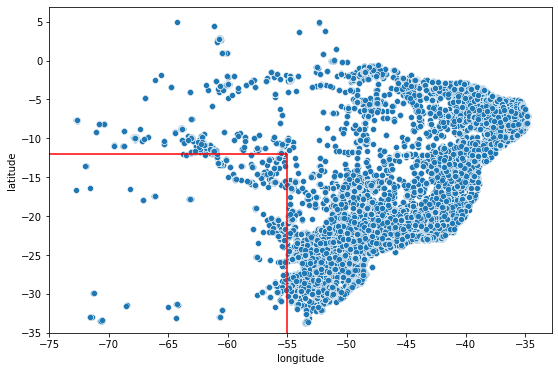

In [18]:
plt.figure(figsize=(9,6))
sns.scatterplot(x=final_df['longitude'], y=final_df['latitude'])
plt.plot([-55, -55, -75], [-35, -12, -12], c='r')
plt.xlim(-75)
plt.ylim(-35)

First we'll deal with the foreign data. We could use the 'geopy' library to check all the coordinates and return their countries' names, but with almost 170.000 different values this would take a very long time, so we need a faster approach.

Knowing that all of the foreign data are in the left side of the map, we can choose a longitude point that would contain all of the foreign coordinates to the left and still doesn't contain too much brazilian points. We decided to draw a vertical line at longitude -53.4.

In [19]:
# Filter left side of map to a new variable
sudamerica = final_df[final_df['longitude'] < -53.4][['client_id', 'coordinates']]
sudamerica.reset_index(drop=True, inplace=True)
sudamerica_uniques = sudamerica['coordinates'].unique()
sudamerica['coordinates'].nunique()

9734

This new section has only 9,734 different coordinates. This will reduce the 'geopy' process to 1 hour and 20 minutes. Since we've already done this, we'll keep the code bellow comented and just import the table in the next cell.

In [20]:
# %%time

# # Instanciate a geolocator and apply the selected coordinates
# import geopy
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent='myGeocoder')

# list_loc = []
# for l in range(len(sudamerica_uniques)):
#     location = geolocator.reverse(sudamerica_uniques[l]).raw['address']['country']
#     list_loc.append(location)

# new_locs = pd.DataFrame(list_loc)

# sudamerica_uniques = pd.DataFrame(sudamerica_uniques)
# outsiders = sudamerica_uniques.merge(new_locs, left_index=True, right_index=True)
# outsiders = outsiders[outsiders['0_y'] != 'Brasil']

# # New dataframe with foreign coordinates and their respective countries
# outsiders

In [21]:
outsiders = pd.read_csv('outsiders.csv')

In [22]:
# Remove rows from 'final_df' with coordinates in 'outsiders'
for coords in outsiders['0_x']:
    final_df = final_df[final_df['coordinates'] != coords]
final_df

,client_id,latitude,longitude,origin,coordinates
247555,000000KK644K269600J6620KD90C82D2,-29.915407,-51.188306,M,"-29.915407,-51.188306"
90071,000000KK644K269600J6620KD90C82D2,-29.910176,-51.189117,C,"-29.910176,-51.189117"
218565,00000294E0KC8KD1K4ECDS6E86S6CK90,-23.550389,-46.554755,M,"-23.550389,-46.554755"
75760,00000294E0KC8KD1K4ECDS6E86S6CK90,-23.518477,-46.500774,C,"-23.518477,-46.500774"
1016019,0000080ED4410C04CKK8K44K0C164046,-21.739523,-41.333635,C,"-21.739523,-41.333635"
...,...,...,...,...,...
21324,SSSJ069448S161J1K4S946KD4246DJC0,-3.778521,-38.514056,M,"-3.778521,-38.514056"
201873,SSSS0196KD6DDK41KE4016D8S12144D9,-22.886630,-47.050366,C,"-22.88663,-47.050366"
437446,SSSS0196KD6DDK41KE4016D8S12144D9,-22.903918,-47.081004,M,"-22.903918,-47.081004"
437450,SSSS0196KD6DDK41KE4016D8S12144D9,-22.880864,-47.069236,M,"-22.880864,-47.069236"


Now we have to deal with the two strange islands in the southeast coast.

In this case we can use the rectangle approach again, filtering to really small areas around them to check their coordinates.

In [23]:
# Display the islands' coordinates
print(final_df[(final_df['longitude'] > -48) & (final_df['longitude'] < -47.5) & (final_df['latitude'] > -26.88) & (final_df['latitude'] < -25.6)]['coordinates'].unique())
final_df[(final_df['longitude'] > -46.5) & (final_df['longitude'] < -45.5) & (final_df['latitude'] > -25.1) & (final_df['latitude'] < -24.5)]['coordinates'].unique()

['-26.59541,-47.911367']


array(['-24.67536,-45.9764'], dtype=object)

Searching for this coordinates on Google Maps, we can see that they're in the middle of the ocean, so we have to discard them

In [24]:
# Drop rows in final_df with these coordinates
final_df = final_df[(final_df['coordinates'] != '-26.59541,-47.911367') & (final_df['coordinates'] != '-24.67536,-45.9764')]
final_df.reset_index(drop=True, inplace=True)
final_df

,client_id,latitude,longitude,origin,coordinates
0,000000KK644K269600J6620KD90C82D2,-29.915407,-51.188306,M,"-29.915407,-51.188306"
1,000000KK644K269600J6620KD90C82D2,-29.910176,-51.189117,C,"-29.910176,-51.189117"
2,00000294E0KC8KD1K4ECDS6E86S6CK90,-23.550389,-46.554755,M,"-23.550389,-46.554755"
3,00000294E0KC8KD1K4ECDS6E86S6CK90,-23.518477,-46.500774,C,"-23.518477,-46.500774"
4,0000080ED4410C04CKK8K44K0C164046,-21.739523,-41.333635,C,"-21.739523,-41.333635"
...,...,...,...,...,...
321862,SSSJ069448S161J1K4S946KD4246DJC0,-3.778521,-38.514056,M,"-3.778521,-38.514056"
321863,SSSS0196KD6DDK41KE4016D8S12144D9,-22.886630,-47.050366,C,"-22.88663,-47.050366"
321864,SSSS0196KD6DDK41KE4016D8S12144D9,-22.903918,-47.081004,M,"-22.903918,-47.081004"
321865,SSSS0196KD6DDK41KE4016D8S12144D9,-22.880864,-47.069236,M,"-22.880864,-47.069236"


### 2.3: checking for 'C' coordinates

In order to keep the model unbiased by the places locations, we need to check and discard clients that doesn't have a 'C' coordinate. For that, we'll create new binary columns and grouped them by 'client_id' to check the sum.

In [25]:
origin_check = final_df.copy()
origin_check['C'] = final_df['origin'].apply(lambda x: 1 if x == 'C' else 0)
origin_check['M'] = final_df['origin'].apply(lambda x: 1 if x == 'M' else 0)
group = origin_check.groupby('client_id', as_index=False).agg({'C': np.sum, 'M': np.sum})
group['C'].value_counts()

1    126270
0      2848
Name: C, dtype: int64

There are 2,848 clients with no 'C' coordinate, so we have to discard them:

In [26]:
# Copy the ids of clients withou 'C' to a variable
no_C = group[group['C'] == 0]['client_id'].values

# Drop rows in final_df with those ids
for user in no_C:
    final_df = final_df[final_df['client_id'] != user]
final_df['client_id'].nunique()

126270

Now our dataframe has 126,271 different clients, all of them having a 'C' and a 'M' coordinates. This is our final dataframe, with clean, real and brazilian based data.

We can visually check the result in the map plotted bellow:

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

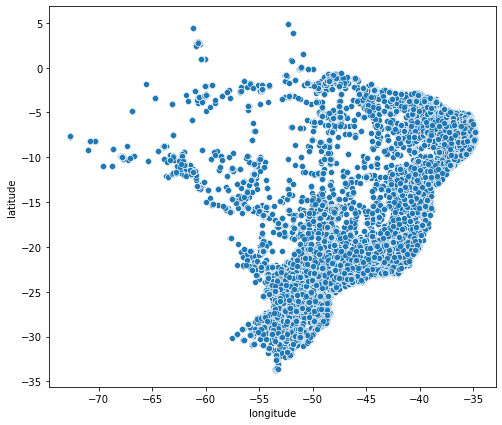

In [27]:
plt.figure(figsize=(8,7))
sns.scatterplot(x=final_df['longitude'], y=final_df['latitude'])

In [28]:
# Display the final_df
final_df

,client_id,latitude,longitude,origin,coordinates
0,000000KK644K269600J6620KD90C82D2,-29.915407,-51.188306,M,"-29.915407,-51.188306"
1,000000KK644K269600J6620KD90C82D2,-29.910176,-51.189117,C,"-29.910176,-51.189117"
2,00000294E0KC8KD1K4ECDS6E86S6CK90,-23.550389,-46.554755,M,"-23.550389,-46.554755"
3,00000294E0KC8KD1K4ECDS6E86S6CK90,-23.518477,-46.500774,C,"-23.518477,-46.500774"
4,0000080ED4410C04CKK8K44K0C164046,-21.739523,-41.333635,C,"-21.739523,-41.333635"
...,...,...,...,...,...
321862,SSSJ069448S161J1K4S946KD4246DJC0,-3.778521,-38.514056,M,"-3.778521,-38.514056"
321863,SSSS0196KD6DDK41KE4016D8S12144D9,-22.886630,-47.050366,C,"-22.88663,-47.050366"
321864,SSSS0196KD6DDK41KE4016D8S12144D9,-22.903918,-47.081004,M,"-22.903918,-47.081004"
321865,SSSS0196KD6DDK41KE4016D8S12144D9,-22.880864,-47.069236,M,"-22.880864,-47.069236"


## 3. Training & building new features

Now that we have our final dataframe with 317,417 rows, we need to feed it to our model. 

### 3.1: K-Means #1


First, we need to prepare the input. After some analysis, we decided that the best way to do that was to give the model only one coordinate per client, taking the mean of all the locations of that client.

In [29]:
# Group final_df by 'client_id'
mean_client = final_df.groupby('client_id', as_index=False).agg({'latitude': np.mean, 'longitude': np.mean})
mean_client

,client_id,latitude,longitude
0,000000KK644K269600J6620KD90C82D2,-29.912792,-51.188712
1,00000294E0KC8KD1K4ECDS6E86S6CK90,-23.534433,-46.527765
2,0000080ED4410C04CKK8K44K0C164046,-21.739764,-41.328006
3,00000961044S122666D66684D869ECC0,-12.829688,-38.811853
4,00001D4CKKE10S84J2KS9C111J49CD60,-29.829447,-51.193097
...,...,...,...
126265,SSSE82K8J4SJ62C46C62J14S4C69E0KD,-23.326407,-51.208790
126266,SSSECS1JSJ106CCD1D4C2DS0642J21J2,-10.164125,-48.355284
126267,SSSED9686681D298S9C4J2D669E0J68J,-13.631978,-41.860001
126268,SSSJ069448S161J1K4S946KD4246DJC0,-3.761861,-38.501167


Now that we have a dataframe with one row per client and their mean location we can feed it to the model.

The KMeans is an unsupervised machine learning model, that labels the data into any given number of clusters. It's the best model to use when dealing with coordinates

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

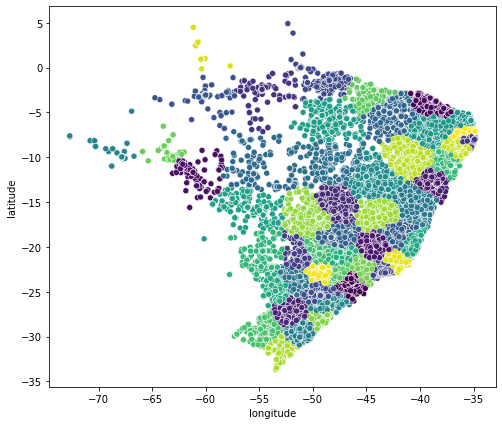

In [30]:
# Copy only necessary features to a new variable
X = mean_client[['latitude', 'longitude']]

# Instanciante the model with 50 clusters and fit it to X
km50 = KMeans(n_clusters=50, random_state=1)
km50.fit(X)

# Plot the original dataframe with designated clusters
plt.figure(figsize=(8,7))
sns.scatterplot(x=X['longitude'], y=X['latitude'], c=km50.labels_)

The map above shows us the division of the 50 clusters the model calculated. It's clear that the northwestern clients are more dispersed while the southeastern clients are more numbered and closely gathered. 


Now that we have the clusters, we need to calculate and analyze their locations and numbers of clients. The model attributes a label/number and a centroid (center location) for each cluster.

In [31]:
# Create a dataframe of centroids' coordinates
centroids = pd.DataFrame(km50.cluster_centers_)
centroids.columns = ['centroid_latitude', 'centroid_longitude']
centroids['coordinates'] = round(centroids['centroid_latitude'], 6).astype(str) + ',' + round(centroids['centroid_longitude'], 6).astype(str)

# Create a dataframe of designated labels per client 
clusters = pd.DataFrame(pd.DataFrame(km50.labels_).value_counts().sort_index())
clusters.columns = ['nb_of_clients']
clusters.reset_index(drop=True, inplace=True)

# Merge them and sorte by number of clients
clusters_info = clusters.merge(centroids, left_index=True, right_index=True)
clusters_info['label'] = clusters_info.index
clusters_info.sort_values('nb_of_clients', ascending=False).head(10)

,nb_of_clients,centroid_latitude,centroid_longitude,coordinates,label
0,27405,-23.573822,-46.614207,"-23.573822,-46.614207",0
10,11148,-22.745481,-43.356864,"-22.745481,-43.356864",10
3,5773,-19.965978,-44.087834,"-19.965978,-44.087834",3
36,5484,-22.983901,-47.308159,"-22.983901,-47.308159",36
21,5262,-29.751277,-51.190245,"-29.751277,-51.190245",21
12,4349,-25.404904,-49.325132,"-25.404904,-49.325132",12
4,4165,-12.758204,-38.648739,"-12.758204,-38.648739",4
8,4086,-8.083679,-35.089252,"-8.083679,-35.089252",8
6,3516,-15.815312,-48.001248,"-15.815312,-48.001248",6
1,3503,-3.970067,-38.625621,"-3.970067,-38.625621",1


The results listed above shows that the top 1 cluster has 27,033 clients and it's centroid is in the city of São Paulo. From this point forward, we'll focus on one of these clusters.


First, we're gonna filter the entire dataset to select only the clients labeled to the top 1 cluster.

In [32]:
# Apply the designated label for each client
km50_results = mean_client.merge(pd.DataFrame(km50.labels_), left_index=True, right_index=True)
km50_results.rename(columns={0: 'label'}, inplace=True)

# New dataframe 'top1', keeping only clients with top 1 label
top1 = km50_results[km50_results['label'] == clusters_info.sort_values('nb_of_clients', ascending=False)['label'].values[0]]
top1

,client_id,latitude,longitude,label
1,00000294E0KC8KD1K4ECDS6E86S6CK90,-23.534433,-46.527765,0
6,00001J606D66640E1KCKEE4890696S89,-23.415139,-46.712938,0
8,000044K4DS26C9CE11KJ2SCJ19SDD66S,-23.971137,-46.278919,0
15,0000C81944CS40D41C6946KC46K104C4,-23.508962,-46.725387,0
25,0000K9CC1C4D6E9KJ66E0E4J6E12K80C,-23.590283,-46.716430,0
...,...,...,...,...
126236,SSS0K1K921C6D1410424068E0E6D6E22,-23.929924,-46.362897,0
126244,SSS4D610048KK8EK694KCCKE166D4C44,-23.550396,-46.762261,0
126249,SSS641KC909J40E2062E0J9K01SJ6K1C,-23.578122,-46.782180,0
126252,SSS69S2600DK6446981EK46464DK2D6J,-23.938770,-46.362225,0


In [33]:
# Drop 'label' column
top1 = top1.drop(columns=['label'])
top1.reset_index(drop=True, inplace=True)
top1

,client_id,latitude,longitude
0,00000294E0KC8KD1K4ECDS6E86S6CK90,-23.534433,-46.527765
1,00001J606D66640E1KCKEE4890696S89,-23.415139,-46.712938
2,000044K4DS26C9CE11KJ2SCJ19SDD66S,-23.971137,-46.278919
3,0000C81944CS40D41C6946KC46K104C4,-23.508962,-46.725387
4,0000K9CC1C4D6E9KJ66E0E4J6E12K80C,-23.590283,-46.716430
...,...,...,...
27400,SSS0K1K921C6D1410424068E0E6D6E22,-23.929924,-46.362897
27401,SSS4D610048KK8EK694KCCKE166D4C44,-23.550396,-46.762261
27402,SSS641KC909J40E2062E0J9K01SJ6K1C,-23.578122,-46.782180
27403,SSS69S2600DK6446981EK46464DK2D6J,-23.938770,-46.362225


Now we have a smaller dataframe containing only the 26,849 clients that the model classified for the label 9.

### 3.2: K-Means #2 (Constrained)

Now we're gonna input the top1 dataframe to a K-Means algorithm again, but with a slight difference: restricting the clusters' size. That's important because the spot must be close to 500 real clients to be financially viable.


In order to do that, we'll use the variant 'K-Means Constrained', that enables the restrictions of size (min and/or max) and number of clusters.

In [34]:
%%time

# Copy features to a new variable
X_top1 = top1[['latitude', 'longitude']]

# Parameters of the model
size_max_model = 5000
size_min_model = 500
max_iter_model = 100

# Instanciate the model and fit
km_top1 = KMeansConstrained(#size_max=size_max_model,
                            size_min=size_min_model,
                            max_iter=max_iter_model,
                            random_state=1)
km_top1.fit(X_top1)

Wall time: 45 s


KMeansConstrained(copy_x=True, init='k-means++', max_iter=100, n_clusters=8,
         n_init=10, n_jobs=1, random_state=1, size_max=None, size_min=500,
         tol=0.0001, verbose=False)

The model returned 8 'sub-clusters'. We'll build a dataframe with important info of each sub-cluster, so we can analyze and decide the best spot to build the physical location.

In [35]:
# Merge sub-clusters' centroids and labels to a new dataframe
centroids_top1 = pd.DataFrame(km_top1.cluster_centers_)
centroids_top1.columns = ['centroid_latitude', 'centroid_longitude']
centroids_top1['centroid_coordinates'] = round(centroids_top1['centroid_latitude'], 6).astype(str)\
                                               + ',' + round(centroids_top1['centroid_longitude'], 6).astype(str)
clusters_top1 = pd.DataFrame(pd.DataFrame(km_top1.labels_).value_counts().sort_index())
clusters_top1.columns = ['nb_of_clients']
clusters_top1.reset_index(drop=True, inplace=True)

results_top1 = pd.merge(centroids_top1, clusters_top1, left_index=True, right_index=True)
results_top1['label'] = results_top1.index

# Display the dataframe
results_top1

,centroid_latitude,centroid_longitude,centroid_coordinates,nb_of_clients,label
0,-23.507181,-46.644446,"-23.507181,-46.644446",6716,0
1,-23.519172,-46.442791,"-23.519172,-46.442791",5034,1
2,-23.955981,-46.366866,"-23.955981,-46.366866",1762,2
3,-24.168993,-47.029034,"-24.168993,-47.029034",500,3
4,-23.162375,-46.691049,"-23.162375,-46.691049",785,4
5,-23.655173,-46.646986,"-23.655173,-46.646986",5425,5
6,-23.553277,-46.819606,"-23.553277,-46.819606",6299,6
7,-23.306372,-45.917203,"-23.306372,-45.917203",884,7


We have a dataframe with all 'sub-clusters' centroids, number of clients and designated label.

In the map bellow we can see the distribution of 'sub-clusters' through São Paulo's area.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

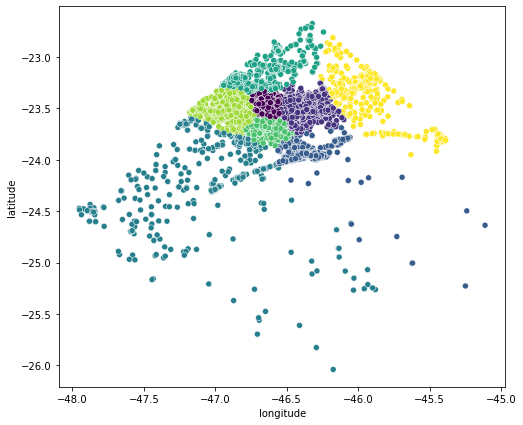

In [36]:
plt.figure(figsize=(8,7))
sns.scatterplot(x=X_top1['longitude'], y=X_top1['latitude'], c=km_top1.labels_)

### 3.3: distance feature

Now we're gonna add some important features of these 'sub-clusters' to improve the analysis and aid the business decision.


The first one will measure the distance between every client and it's designated centroid, using a navigation formula called 'haversine', that takes coordinates and returns the distance in km; luckily for us, there's a python's library for that.

In [37]:
# Merge top1 with labels
distance_top1 = top1.merge(pd.DataFrame(km_top1.labels_), left_index=True, right_index=True)
distance_top1.rename(columns={0: 'label'}, inplace=True)

# Add centroids' coordinates to each client, to enable distance calculation
distance_top1['centroid_coord'] = None
for row in range(len(results_top1)):
    distance_top1.loc[distance_top1['label'] == results_top1['label'][row], 'centroid_coord' ]\
                      = results_top1['centroid_coordinates'][row]

# Split centroids' coordinates to 'centroid_lat' and 'centroid_long' and rename the clients' lat and long
distance_top1['centroid_lat'] = distance_top1['centroid_coord'].apply(lambda x: x.split(',')[0]).astype(float)
distance_top1['centroid_long'] = distance_top1['centroid_coord'].apply(lambda x: x.split(',')[1]).astype(float)
distance_top1.rename(columns={'latitude': 'client_lat','longitude': 'client_long'}, inplace=True)

# Apply 'haversine' method to a column 'distance_km'
distance_top1['distance_km'] = 0.0
for row in distance_top1.index:
    distance_top1['distance_km'][row] = round(haversine(
                                              [distance_top1['client_lat'][row], distance_top1['client_long'][row]],
                                              [distance_top1['centroid_lat'][row], distance_top1['centroid_long'][row]]), 2)
distance_top1.head(10)

<ipython-input-37-e6a89265e3be>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distance_top1['distance_km'][row] = round(haversine(


,client_id,client_lat,client_long,label,centroid_coord,centroid_lat,centroid_long,distance_km
0,00000294E0KC8KD1K4ECDS6E86S6CK90,-23.534433,-46.527765,1,"-23.519172,-46.442791",-23.519172,-46.442791,8.83
1,00001J606D66640E1KCKEE4890696S89,-23.415139,-46.712938,0,"-23.507181,-46.644446",-23.507181,-46.644446,12.39
2,000044K4DS26C9CE11KJ2SCJ19SDD66S,-23.971137,-46.278919,2,"-23.955981,-46.366866",-23.955981,-46.366866,9.09
3,0000C81944CS40D41C6946KC46K104C4,-23.508962,-46.725387,0,"-23.507181,-46.644446",-23.507181,-46.644446,8.26
4,0000K9CC1C4D6E9KJ66E0E4J6E12K80C,-23.590283,-46.716430,5,"-23.655173,-46.646986",-23.655173,-46.646986,10.11
5,0000S6C66E982D216S4108D9D8D4ED08,-23.569102,-46.649103,0,"-23.507181,-46.644446",-23.507181,-46.644446,6.90
6,00012K9D6806JS60008SD0926600S099,-23.681533,-46.688810,5,"-23.655173,-46.646986",-23.655173,-46.646986,5.17
7,0001464S68D89EC064JS01E68401KS0J,-23.515949,-46.781816,6,"-23.553277,-46.819606",-23.553277,-46.819606,5.66
8,0001C006EDS420JJ84166E604K40C661,-23.675511,-46.640035,5,"-23.655173,-46.646986",-23.655173,-46.646986,2.37
9,0001C6914KD6040CKKD1882660S260K9,-23.554592,-46.873176,6,"-23.553277,-46.819606",-23.553277,-46.819606,5.46


Now, the 'distance_top1' enables us to take the mean distance between clients and centroids per 'sub-cluster'. Then, we can merge this with the 'results_top1' dataframe and add some extra distance features to it.

In [38]:
# Take the mean and max distance per cluster
mean_dist_label = distance_top1.groupby('label').agg({'distance_km': [np.mean, np.max]})

# Merge the results
final_top1 = results_top1.merge(round(mean_dist_label, 2), left_index=True, right_index=True )
final_top1.rename(columns={final_top1.columns[-2]: 'mean_distance', final_top1.columns[-1]: 'max_distance'}, inplace=True)

# creating new columns that shows the 1st, 2nd and 3rd quartile for each cluster:
for i in range(len(final_top1)):
    final_top1.loc[i,'25%'] = round(distance_top1[distance_top1['label'] == i]['distance_km'].describe().loc['25%'], 2)
    final_top1.loc[i,'50%'] = round(distance_top1[distance_top1['label'] == i]['distance_km'].describe().loc['50%'], 2)
    final_top1.loc[i,'75%'] = round(distance_top1[distance_top1['label'] == i]['distance_km'].describe().loc['75%'], 2)
final_top1.sort_values('75%', inplace=True)
final_top1.reset_index(drop=True, inplace=True)
final_top1.head(10)

C:\Users\franc\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,centroid_latitude,centroid_longitude,centroid_coordinates,nb_of_clients,label,mean_distance,max_distance,25%,50%,75%
0,-23.507181,-46.644446,"-23.507181,-46.644446",6716,0,7.28,21.43,5.13,7.23,9.19
1,-23.655173,-46.646986,"-23.655173,-46.646986",5425,5,7.88,24.26,5.31,7.73,10.09
2,-23.553277,-46.819606,"-23.553277,-46.819606",6299,6,9.18,36.73,5.90,8.49,11.23
3,-23.955981,-46.366866,"-23.955981,-46.366866",1762,2,9.03,181.02,3.21,6.90,11.49
4,-23.519172,-46.442791,"-23.519172,-46.442791",5034,1,9.89,36.30,5.73,9.27,12.67
5,-23.306372,-45.917203,"-23.306372,-45.917203",884,7,19.38,82.86,8.86,12.18,18.66
6,-23.162375,-46.691049,"-23.162375,-46.691049",785,4,19.69,66.02,13.57,17.49,23.46
7,-24.168993,-47.029034,"-24.168993,-47.029034",500,3,50.95,225.15,31.18,43.88,61.46


### 3.4: distribution features

Now we have a dataframe presenting all of top1's 'sub-clusters' and some important features of them. The first sub-cluster of the table above has 6,369 clients, with a mean distance between clients and centroid of 6.60 km, and the most distant client is 21.76 km far from the centroid. Also, 75% of all clients of this sub-cluster are inside a radius of 8.39 km.


The plot bellow shows the distribution the top 4 sub-clusters: <font color='blue'>clients</font> and <font color='red'>centroids</font>

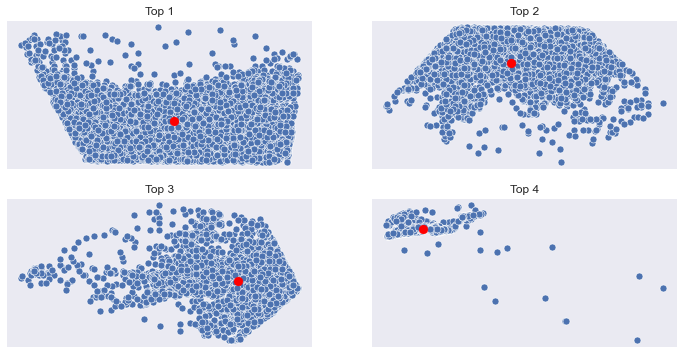

In [39]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn')

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(f'Top {i+1}')
    sns.scatterplot(x=distance_top1[distance_top1['label'] == final_top1['label'][i]]['client_long'],
                    y=distance_top1[distance_top1['label'] == final_top1['label'][i]]['client_lat'])
    plt.scatter(x=final_top1['centroid_longitude'][i], y=final_top1['centroid_latitude'][i], color='r', s=80)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])

### 3.5: geographic features


Now we'll add geographical info to the dataframe by using 'geopy' module once more. This python package accepts coordinates as inputs and returns all the hole address of it.

In [40]:
# Instanciate the geolocator
geolocator = Nominatim(user_agent="myGeocoder")

# Extract location info and add to a new dataframe 'location'
keys = ['suburb', 'town', 'city', 'county', 'state']
list_loc = []

for l in range(len(final_top1['centroid_coordinates'])):
    try:
        location = geolocator.reverse(final_top1['centroid_coordinates'][l])
        dict_location = location.raw['address']
    except:
        dict_location = dict(keys = ['suburb', 'town', 'city', 'county', 'state'])
    for key in keys:
        dict_location = {key: dict_location.get(key) for key in keys}
    list_loc.append(dict_location)

geo_location = pd.DataFrame(list_loc)

# Copy 'centroid_coordinates' and merge with final_top1
geo_location['centroid_coordinates'] = final_top1['centroid_coordinates']
geo_clusters = final_top1.merge(geo_location, on='centroid_coordinates')

# Merge 'town' and 'city' and drop useless columns
for row in range(len(geo_clusters['city'])):
    if (geo_clusters['city'][row] == None) & (geo_clusters['town'][row] == None):
        geo_clusters['city'][row] = geo_clusters['county'][row].split('de ')[-1]
    elif (geo_clusters['city'][row] == None) & (geo_clusters['town'][row] != None):
        geo_clusters['city'][row] = geo_clusters['town'][row]
geo_clusters.drop(columns=['centroid_latitude', 'centroid_longitude', 'town', 'county'], inplace=True)
geo_clusters

<ipython-input-40-7bb54290b7f4>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_clusters['city'][row] = geo_clusters['town'][row]


,centroid_coordinates,nb_of_clients,label,mean_distance,max_distance,25%,50%,75%,suburb,city,state
0,"-23.507181,-46.644446",6716,0,7.28,21.43,5.13,7.23,9.19,Santana,São Paulo,São Paulo
1,"-23.655173,-46.646986",5425,5,7.88,24.26,5.31,7.73,10.09,Jabaquara,São Paulo,São Paulo
2,"-23.553277,-46.819606",6299,6,9.18,36.73,5.90,8.49,11.23,Osasco,Osasco,São Paulo
3,"-23.955981,-46.366866",1762,2,9.03,181.02,3.21,6.90,11.49,None,São Vicente,São Paulo
4,"-23.519172,-46.442791",5034,1,9.89,36.30,5.73,9.27,12.67,Vila Chavantes,São Paulo,São Paulo
5,"-23.306372,-45.917203",884,7,19.38,82.86,8.86,12.18,18.66,Jardim Colônia,Jacareí,São Paulo
6,"-23.162375,-46.691049",785,4,19.69,66.02,13.57,17.49,23.46,None,Jarinu,São Paulo
7,"-24.168993,-47.029034",500,3,50.95,225.15,31.18,43.88,61.46,None,Peruíbe,São Paulo


### 3.6: economic feature

We're also gonna add the 'GDP per capita' of each city to help evaluate the centroids and aid the decision about the place.
We'll do this by importing a done table with this information for every city in Brazil and merging with our dataframe.

In [41]:
# Import 'gdp_percapita' table
gdp_pc = pd.read_csv('gdp_percapita_UF.csv')
gdp_pc.head(10)

,city,UF,gdp_pc_R$
0,Tremedal,BA,3140.24
1,Turuçu,RS,11430.97
2,Vitória,ES,61790.59
3,Jacutinga,MG,11567.21
4,Nazária,PI,2653.75
5,Pedra Azul,MG,7212.45
6,Teresina,PI,10841.20
7,Amarante,PI,3650.95
8,Matrinchã,GO,10387.00
9,Cachoeirinha,PE,4438.22


In [42]:
# Add gdp per capita to geo_clusters
geo_clusters = geo_clusters.merge(gdp_pc[gdp_pc['UF'] == 'SP'], on='city', how='left')
geo_clusters

,centroid_coordinates,nb_of_clients,label,mean_distance,max_distance,25%,50%,75%,suburb,city,state,UF,gdp_pc_R$
0,"-23.507181,-46.644446",6716,0,7.28,21.43,5.13,7.23,9.19,Santana,São Paulo,São Paulo,SP,35271.93
1,"-23.655173,-46.646986",5425,5,7.88,24.26,5.31,7.73,10.09,Jabaquara,São Paulo,São Paulo,SP,35271.93
2,"-23.553277,-46.819606",6299,6,9.18,36.73,5.90,8.49,11.23,Osasco,Osasco,São Paulo,SP,43994.47
3,"-23.955981,-46.366866",1762,2,9.03,181.02,3.21,6.90,11.49,None,São Vicente,São Paulo,SP,8761.79
4,"-23.519172,-46.442791",5034,1,9.89,36.30,5.73,9.27,12.67,Vila Chavantes,São Paulo,São Paulo,SP,35271.93
5,"-23.306372,-45.917203",884,7,19.38,82.86,8.86,12.18,18.66,Jardim Colônia,Jacareí,São Paulo,SP,22705.97
6,"-23.162375,-46.691049",785,4,19.69,66.02,13.57,17.49,23.46,None,Jarinu,São Paulo,SP,17486.51
7,"-24.168993,-47.029034",500,3,50.95,225.15,31.18,43.88,61.46,None,Peruíbe,São Paulo,SP,10653.18


Now we have a dataframe with all 8 optimal coordinates that our model returned, in addition to some important info on each one of them: 

- number of clients 
- mean and max distance (client x centroid) 
- 1st, 2nd and 3rd quartile (distribution) 
- location info (suburb, city, state)
- GDP per capita of the city 

We believe this is enough to make a smart business decision about building the physical location.

## Extra 1: Zap Imóveis scrapping


As an extra content, our project also offers real estate information. Once you've chosen the best potential(s) spots based on our model's output, we'll show you all empty lands available in that suburb registered on 'Zap Imóveis', one of the top real estate websites in Brazil.


For instance, we choose the 1st sub-cluster's suburb:

In [45]:
# Create a string with suburb's name
suburb = 'Santana'

In [46]:
# Create column in scrapping format
geo_clusters['param_scrapping'] = (geo_clusters['UF'] +'+'+ geo_clusters["city"].replace(' ','-',regex=True)\
                                  +'++'+geo_clusters["suburb"].replace(' ','-',regex=True)).str.normalize('NFKD')\
                                  .str.encode('ascii', errors='ignore')\
                                  .str.decode('utf-8').str.lower()

# Copy index of chosen suburb to a new variable 
sub_index = geo_clusters[geo_clusters['suburb'] == suburb]['param_scrapping'].index[0]

# Execute scrapping process using 'zapimoveis_scrapper'
scrapping_info = []
tipo = "terrenos-lotes-comerciais" #galpao-deposito-armazem
pages = 10
acao = 'venda'

try:
    param_scrapping = geo_clusters["param_scrapping"][sub_index].replace('vila', 'vl')
    df_forloop = zap.search(localization=param_scrapping, num_pages=pages, tipo=tipo, dictionary_out=True, acao=acao)
    df_forloop = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in df_forloop.items() ]))
    df_forloop['city'] = geo_clusters["city"][sub_index]
    df_forloop['state'] = geo_clusters["state"][sub_index]
    df_forloop['suburb'] = geo_clusters["suburb"][sub_index]
    scrapping_info.append(df_forloop)
    scrapping_info = pd.concat(scrapping_info)
except:
    print('Sorry! There are currently zero options available for this suburb in Zap Imóveis')
    pass
scrapping_info

,price,bedrooms,bathrooms,vacancies,total_area_m2,address,description,link,city,state,suburb
0,3000000,0,0,0,594,"Rua Bem Vinda Apparecida de Abreu Leme, Santana","Terreno comercial à venda, Santana, São Paulo.",/imovel/venda-terreno-lote-comercial-santana-z...,São Paulo,São Paulo,Santana
1,2800000,0,0,0,356,"Rua Bem Vinda Apparecida de Abreu Leme, Santana","Terreno comercial à venda, Santana, São Paulo.",/imovel/venda-terreno-lote-comercial-santana-z...,São Paulo,São Paulo,Santana
2,2300000,0,0,0,270,Santana,TERRENO SANTANA,/imovel/venda-terreno-lote-comercial-santana-z...,São Paulo,São Paulo,Santana
3,2820000,0,0,0,470,"Rua Conselheiro Moreira de Barros, Santana",Terreno em Santana,/imovel/venda-terreno-lote-comercial-santana-z...,São Paulo,São Paulo,Santana
4,1600000,0,0,0,489,Santana,Terreno à Venda em Santana com 479 m²,/imovel/venda-terreno-lote-comercial-santana-z...,São Paulo,São Paulo,Santana
...,...,...,...,...,...,...,...,...,...,...,...
81,10000000,0,0,0,1220,"Rua Major Sampaio, Santana",AREA - SANTANA - SP,/imovel/venda-terreno-lote-comercial-santana-z...,São Paulo,São Paulo,Santana
82,2845000,0,0,0,947,"Rua Copacabana, Santana","Terreno Santana ,947 metros quadrados",/imovel/venda-terreno-lote-comercial-santana-z...,São Paulo,São Paulo,Santana
83,2650000,0,1,0,780,"Rua Doutor Gabriel Piza, Santana","Terreno a Venda com 780,00 M² em Santana, São ...",/imovel/venda-terreno-lote-comercial-santana-z...,São Paulo,São Paulo,Santana
84,15000,0,0,0,1000,"Rua Jovita, Santana",área - Santana - São Paulo,/imovel/venda-terreno-lote-comercial-com-quint...,São Paulo,São Paulo,Santana


The output shows 86 available empty land for sell in the suburb of 'Santana', in the city of São Paulo, in addition to the price, area in m2, address, description and the link of the place at Zap Imóveis website.

## Extra 2: K-Means #3

What about the results for other clusters? In the next cell we run the results for the top 2 cluster, based on the state of Rio de Janeiro:

<timed exec>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\franc\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


Wall time: 16.5 s


<timed exec>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,centroid_coordinates,nb_of_clients,label,mean_distance,max_distance,25%,50%,75%,suburb,city,state
0,"-22.849081,-43.086844",1476,6,6.78,23.20,4.03,6.18,8.60,Vila Lage,São Gonçalo,Rio de Janeiro
1,"-22.895201,-43.3055",3362,5,7.49,20.89,4.63,7.31,9.83,Piedade,Rio de Janeiro,Rio de Janeiro
2,"-22.775844,-43.41051",2518,1,8.03,50.78,4.74,7.42,10.35,Industrial,Mesquita,Rio de Janeiro
3,"-21.753464,-43.422171",645,2,11.91,79.44,4.73,5.78,8.53,Pedra Bonita,Juiz de Fora,Minas Gerais
4,"-22.868719,-43.619454",1330,7,11.95,94.93,5.88,9.95,16.68,Piranema,Seropédica,Rio de Janeiro
5,"-22.4688,-43.156818",680,4,16.88,51.63,8.65,16.84,19.73,Cascatinha,Petrópolis,Rio de Janeiro
6,"-22.788076,-42.764306",500,0,20.82,59.07,14.19,18.03,23.16,None,Tanguá,Rio de Janeiro
7,"-22.608342,-44.10571",637,3,26.61,102.23,12.56,16.40,42.18,Boa Vista I,Barra Mansa,Rio de Janeiro


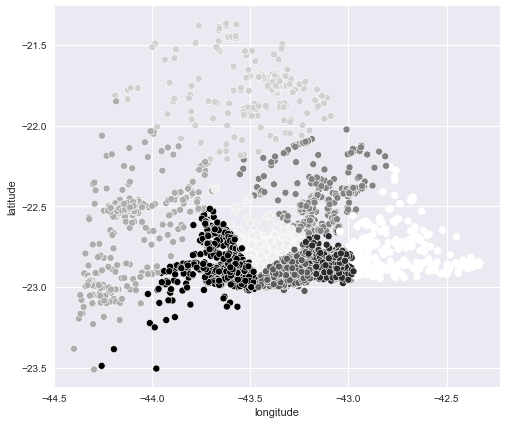

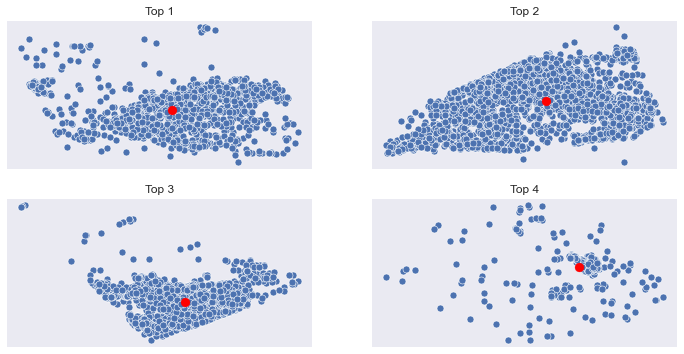

In [47]:
%%time

km50_results = mean_client.merge(pd.DataFrame(km50.labels_), left_index=True, right_index=True)
km50_results.rename(columns={0: 'label'}, inplace=True)
top2 = km50_results[km50_results['label'] == clusters_info.sort_values('nb_of_clients', ascending=False)['label'].values[1]]
top2 = top2.drop(columns=['label'])
top2.reset_index(drop=True, inplace=True)
X_top2 = top2[['latitude', 'longitude']]
km_top2 = KMeansConstrained(size_min=500,max_iter=100,random_state=1)
km_top2.fit(X_top2)
centroids_top2 = pd.DataFrame(km_top2.cluster_centers_)
centroids_top2.columns = ['centroid_latitude', 'centroid_longitude']
centroids_top2['centroid_coordinates'] = round(centroids_top2['centroid_latitude'], 6).astype(str)\
                                               + ',' + round(centroids_top2['centroid_longitude'], 6).astype(str)
clusters_top2 = pd.DataFrame(pd.DataFrame(km_top2.labels_).value_counts().sort_index())
clusters_top2.columns = ['nb_of_clients']
clusters_top2.reset_index(drop=True, inplace=True)
results_top2 = pd.merge(centroids_top2, clusters_top2, left_index=True, right_index=True)
results_top2['label'] = results_top2.index
plt.figure(figsize=(8,7))
sns.scatterplot(x=X_top2['longitude'], y=X_top2['latitude'], c=km_top2.labels_)
distance_top2 = top2.merge(pd.DataFrame(km_top2.labels_), left_index=True, right_index=True)
distance_top2.rename(columns={0: 'label'}, inplace=True)
distance_top2['centroid_coord'] = None
for row in range(len(results_top2)):
    distance_top2.loc[distance_top2['label'] == results_top2['label'][row], 'centroid_coord' ]\
                      = results_top2['centroid_coordinates'][row]
distance_top2['centroid_lat'] = distance_top2['centroid_coord'].apply(lambda x: x.split(',')[0]).astype(float)
distance_top2['centroid_long'] = distance_top2['centroid_coord'].apply(lambda x: x.split(',')[1]).astype(float)
distance_top2.rename(columns={'latitude': 'client_lat','longitude': 'client_long'}, inplace=True)
distance_top2['distance_km'] = 0.0
for row in distance_top2.index:
    distance_top2['distance_km'][row] = round(haversine(
                                              [distance_top2['client_lat'][row], distance_top2['client_long'][row]],
                                              [distance_top2['centroid_lat'][row], distance_top2['centroid_long'][row]]), 2)
mean_dist_label = distance_top2.groupby('label').agg({'distance_km': [np.mean, np.max]})
final_top2 = results_top2.merge(round(mean_dist_label, 2), left_index=True, right_index=True )
final_top2.rename(columns={final_top2.columns[-2]: 'mean_distance', final_top2.columns[-1]: 'max_distance'}, inplace=True)
for i in range(len(final_top2)):
    final_top2.loc[i,'25%'] = round(distance_top2[distance_top2['label'] == i]['distance_km'].describe().loc['25%'], 2)
    final_top2.loc[i,'50%'] = round(distance_top2[distance_top2['label'] == i]['distance_km'].describe().loc['50%'], 2)
    final_top2.loc[i,'75%'] = round(distance_top2[distance_top2['label'] == i]['distance_km'].describe().loc['75%'], 2)
final_top2.sort_values('mean_distance', inplace=True)
final_top2.reset_index(drop=True, inplace=True)
plt.figure(figsize=(12, 6))
plt.style.use('seaborn')
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(f'Top {i+1}')
    sns.scatterplot(x=distance_top2[distance_top2['label'] == final_top2['label'][i]]['client_long'],
                    y=distance_top2[distance_top2['label'] == final_top2['label'][i]]['client_lat'])
    plt.scatter(x=final_top2['centroid_longitude'][i], y=final_top2['centroid_latitude'][i], color='r', s=80)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])
geolocator = Nominatim(user_agent="myGeocoder")
keys = ['suburb', 'town', 'city', 'state']
list_loc = []
for l in range(len(final_top2['centroid_coordinates'])):
    try:
        location = geolocator.reverse(final_top2['centroid_coordinates'][l])
        dict_location = location.raw['address']
    except:
        dict_location = dict(keys = ['suburb', 'town', 'city', 'state'])
    for key in keys:
        dict_location = {key: dict_location.get(key) for key in keys}
    list_loc.append(dict_location)
location = pd.DataFrame(list_loc)
location['centroid_coordinates'] = final_top2['centroid_coordinates']
geo_clusters2 = final_top2.merge(location, on='centroid_coordinates')
for row in range(len(geo_clusters2['city'])):
    if geo_clusters2['city'][row] == None:
        geo_clusters2['city'][row] = geo_clusters2['town'][row]
geo_clusters2.drop(columns=['centroid_latitude', 'centroid_longitude', 'town'], inplace=True)
geo_clusters2.head(10)
gdp_pc = pd.read_csv('gdp_percapita_UF.csv')
geo_clusters2

## Conclusion

In this project we cleaned, analyzed and trained data from an app that intermediates people and places, to help them decide the best spot to build a physical location.

First, we received millions of raw data observations to clean. The output here was a dataframe close to 300k rows, containing only real clients based on Brazil that went to at least one place and shared their cellphone coordinates.

The second step was to group our datafame by 'client_id' and take the mean coordinates of each client, as a quick and valid measure of one's 'mean location', having so only one coordinate per client. This was the input used to train our machine learning model, K-Means, in order to split our dataset into a given number of clusters.  The output was a division of 50 clusters around the brazilian area. The top 10 clusters have a considerable number of clients, and can be used for the next step of the project, a deeper analysis of a cluster.

The third step was to filter the final clients' dataframe and select only clients of a chosen cluster. Then we used them as input to another model called K-Means constrained, that allows you to limit the size of the new clusters. So the output was a division of sub-clusters, with maximum size of 1500 clients each, and the centroid's coordinates for each sub-cluster. We then added some important features to help evaluate the optimal coordinates the model returned to us, like distance (km), distribution, geographical and economical info of the area.

As an extra step, our model provides real estate info of 'Zap Imóveis', one of the greatest websites on this matter, by only typing the name of the suburb to be searched for.

We believe that this project will help the app to choose the best spot to build their new location.